In [31]:
import os
import glob
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import torch
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ResizeWithPadOrCropd, ToTensord
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import BasicUNet
from monai.losses import DiceCELoss
from torch.optim import Adam
from torch.utils.data import random_split

# ==== USER PATHS ====
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = os.path.join(DICOM_ROOT, "ProstateX-Findings-Train100.csv")
IMAGES_CSV = os.path.join(DICOM_ROOT, "ProstateX-Images-Train100.csv")

# ==== READ CSVs ====
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)
meta_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"])

# ==== UTILS ====
def load_dicom_volume(proxid, series_description="ADC"):
    patient_dir = os.path.join(DICOM_ROOT, proxid)
    for root, dirs, files in os.walk(patient_dir):
        if series_description.lower() in root.lower():
            dicoms = sorted(glob.glob(os.path.join(root, "*.dcm")))
            if dicoms:
                reader = sitk.ImageSeriesReader()
                reader.SetFileNames(dicoms)
                return reader.Execute()
    raise FileNotFoundError(f"No DICOM series found for {proxid} with '{series_description}'")

def load_ktrans(proxid):
    path = os.path.join(KTRANS_DIR, proxid, f"{proxid}-Ktrans.mhd")
    if not os.path.exists(path):
        raise FileNotFoundError(f"No Ktrans found for {proxid}")
    return sitk.ReadImage(path)

def parse_ijk(ijk_str):
    try:
        return tuple(map(int, ijk_str.replace(",", " ").split()))
    except:
        return None

def generate_label_mask(image, ijk_list):
    arr = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        try: arr[k, j, i] = 1
        except: continue
    mask = sitk.GetImageFromArray(arr)
    mask.CopyInformation(image)
    return mask

# ==== OUTPUT FOLDERS ====
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)

# ==== BUILD DATA ====
data = []
print("\n📦 Building dataset...\n")
for proxid in tqdm(meta_df["ProxID"].unique()):
    try:
        adc_img = load_dicom_volume(proxid)
        ktrans_img = load_ktrans(proxid)
        ktrans_img = sitk.Resample(ktrans_img, adc_img)
        lesions = meta_df[meta_df["ProxID"] == proxid]["ijk"].dropna()
        coords = [parse_ijk(ijk) for ijk in lesions if parse_ijk(ijk)]
        if not coords: continue
        label_img = generate_label_mask(adc_img, coords)

        adc_path = f"images/{proxid}_adc.nii.gz"
        ktr_path = f"images/{proxid}_ktrans.nii.gz"
        lbl_path = f"labels/{proxid}_label.nii.gz"

        sitk.WriteImage(adc_img, adc_path)
        sitk.WriteImage(ktrans_img, ktr_path)
        sitk.WriteImage(label_img, lbl_path)

        data.append({
            "image": [adc_path, ktr_path],
            "label": lbl_path
        })
    except Exception as e:
        print(f"❌ Failed on {proxid}: {e}")

print(f"\n✅ Total usable samples: {len(data)}")
if len(data) == 0:
    raise RuntimeError("No usable training samples.")




📦 Building dataset...



100%|██████████| 101/101 [00:14<00:00,  7.07it/s]


✅ Total usable samples: 101


In [33]:
# ==== TRANSFORMS ====
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(64, 64, 32)),
    ToTensord(keys=["image", "label"]),
])

# ==== SPLIT TRAIN/TEST ====
full_ds = Dataset(data=data, transform=transforms)
train_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_size
train_ds, test_ds = random_split(full_ds, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)


In [39]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [35]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [41]:

# ==== MODEL ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicUNet(spatial_dims=3, in_channels=2, out_channels=2).to(device)
loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), lr=1e-4)

# ==== TRAIN ====
print("\n🚀 Starting training...\n")
for epoch in range(10):
    model.train()
    epoch_loss = 0
    start = time.time()
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        epoch_loss += loss.item()
    print(f"[Epoch {epoch+1}] Avg Loss: {epoch_loss:.4f} ⏱ {time.time()-start:.2f}s")

torch.save(model.state_dict(), "prostate_seg_model.pth")
print("\n✅ Model saved as 'prostate_seg_model.pth'")
"""
# ==== EVALUATE ON TEST SET ====
print("\n📊 Evaluating model...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        x = batch["image"].to(device)
        y = batch["label"].to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().flatten()
        true = y.cpu().flatten()
        all_preds.extend(preds)
        all_labels.extend(true)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)

print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# ==== PLOT METRICS ====
metrics = [accuracy, precision, recall, f1]
labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
plt.figure(figsize=(8, 4))
plt.bar(labels, metrics, color=["skyblue", "orange", "lightgreen", "orchid"])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Evaluation on Test Set")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()"""


BasicUNet features: (32, 32, 64, 128, 256, 32).

🚀 Starting training...

[Epoch 1] Avg Loss: 88.8083 ⏱ 21.57s
[Epoch 2] Avg Loss: 73.5413 ⏱ 17.52s
[Epoch 3] Avg Loss: 67.6526 ⏱ 17.64s
[Epoch 4] Avg Loss: 63.4603 ⏱ 17.77s
[Epoch 5] Avg Loss: 60.1691 ⏱ 17.51s
[Epoch 6] Avg Loss: 57.4330 ⏱ 17.34s
[Epoch 7] Avg Loss: 55.1754 ⏱ 17.32s
[Epoch 8] Avg Loss: 53.2534 ⏱ 17.46s
[Epoch 9] Avg Loss: 51.6405 ⏱ 17.36s
[Epoch 10] Avg Loss: 50.2727 ⏱ 17.42s

✅ Model saved as 'prostate_seg_model.pth'


'\n# ==== EVALUATE ON TEST SET ====\nprint("\n📊 Evaluating model...")\nmodel.eval()\nall_preds, all_labels = [], []\n\nwith torch.no_grad():\n    for batch in test_loader:\n        x = batch["image"].to(device)\n        y = batch["label"].to(device)\n        logits = model(x)\n        preds = torch.argmax(logits, dim=1).cpu().flatten()\n        true = y.cpu().flatten()\n        all_preds.extend(preds)\n        all_labels.extend(true)\n\naccuracy = accuracy_score(all_labels, all_preds)\nprecision = precision_score(all_labels, all_preds, zero_division=0)\nrecall = recall_score(all_labels, all_preds, zero_division=0)\nf1 = f1_score(all_labels, all_preds, zero_division=0)\n\nprint(f"✅ Accuracy:  {accuracy:.4f}")\nprint(f"✅ Precision: {precision:.4f}")\nprint(f"✅ Recall:    {recall:.4f}")\nprint(f"✅ F1 Score:  {f1:.4f}")\n\n# ==== PLOT METRICS ====\nmetrics = [accuracy, precision, recall, f1]\nlabels = ["Accuracy", "Precision", "Recall", "F1 Score"]\nplt.figure(figsize=(8, 4))\nplt.bar(labe


🧪 Starting evaluation on test subset...


✅ Accuracy:  1.0000
✅ Precision: 0.0000
✅ Recall:    0.0000
✅ F1 Score:  0.0000


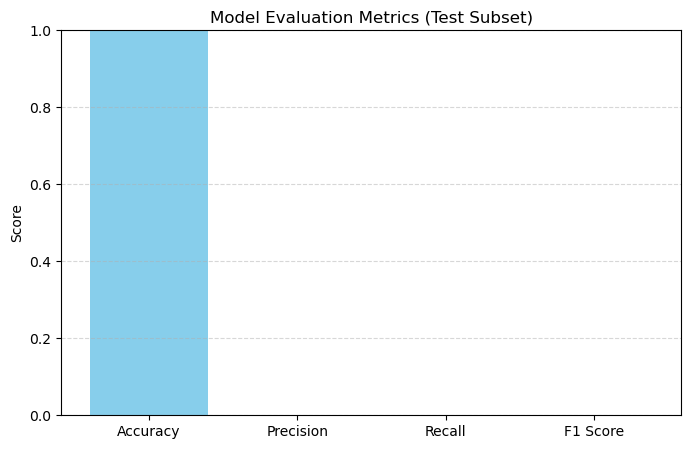

In [13]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n🧪 Starting evaluation on test subset...\n")
model.eval()

# Switch to CPU if needed
device_eval = torch.device("cpu")

# Pick random 10 samples from test set
test_subset = random.sample(list(test_loader), k=min(10, len(test_loader)))

y_true_all = []
y_pred_all = []

with torch.no_grad():
    for i, batch in enumerate(test_subset):
        images = batch["image"].to(device_eval)
        labels = batch["label"].to(device_eval)

        # Skip empty masks (no lesions)
        if labels.sum() == 0:
            print(f"⚠️ Skipping sample {i+1} (empty mask)")
            continue

        outputs = model(images.to(device))
        preds = torch.argmax(outputs, dim=1).to(device_eval)  # shape: [B, D, H, W] or similar

        y_true_all.extend(labels.cpu().numpy().flatten())
        y_pred_all.extend(preds.cpu().numpy().flatten())

# === Compute Metrics ===
accuracy = accuracy_score(y_true_all, y_pred_all)
precision = precision_score(y_true_all, y_pred_all, zero_division=0)
recall = recall_score(y_true_all, y_pred_all, zero_division=0)
f1 = f1_score(y_true_all, y_pred_all, zero_division=0)

print(f"\n✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# === Bar Plot ===
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title("Model Evaluation Metrics (Test Subset)")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()



🧪 Running full test set evaluation...


📊 Full Test Set Metrics:
✅ Accuracy:  1.0000
✅ Precision: 0.0000
✅ Recall:    0.0000
✅ F1 Score:  0.0000


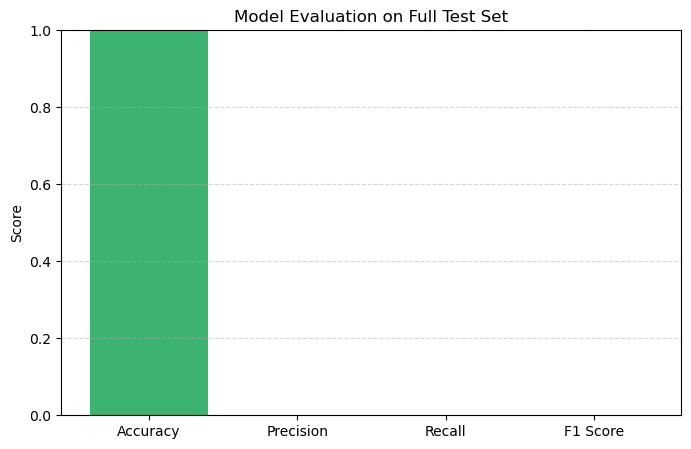

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print("\n🧪 Running full test set evaluation...\n")
model.eval()

y_true_all = []
y_pred_all = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        # Skip if ground truth is completely empty (optional)
        if labels.sum() == 0:
            print(f"⚠️ Skipping empty mask at batch {i+1}")
            continue

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # shape: [B, D, H, W]

        y_pred_all.extend(preds.cpu().numpy().flatten())
        y_true_all.extend(labels.cpu().numpy().flatten())

# === Compute Metrics ===
accuracy = accuracy_score(y_true_all, y_pred_all)
precision = precision_score(y_true_all, y_pred_all, zero_division=0)
recall = recall_score(y_true_all, y_pred_all, zero_division=0)
f1 = f1_score(y_true_all, y_pred_all, zero_division=0)

print(f"\n📊 Full Test Set Metrics:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# === Bar Plot ===
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='mediumseagreen')
plt.ylim(0, 1)
plt.title("Model Evaluation on Full Test Set")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [17]:
from monai.losses import DiceCELoss
import time
import torch

# Use foreground-focused DiceCELoss
loss_fn = DiceCELoss(
    to_onehot_y=True,
    softmax=True,
    include_background=False  # 👈 Ignore background class in loss
)

print("\n🚀 Starting training with foreground-focused loss...\n")

for epoch in range(10):
    print(f"\n--- Epoch {epoch + 1} ---")
    model.train()
    epoch_loss = 0
    start_time = time.time()

    for batch_idx, batch in enumerate(train_loader):
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Optional GPU memory cleanup
        torch.cuda.empty_cache()

        epoch_loss += loss.item()
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"📦 Batch {batch_idx + 1}/{len(train_loader)} — Loss: {loss.item():.4f}")

    elapsed = time.time() - start_time
    print(f"✅ Epoch {epoch + 1} completed — Avg Loss: {epoch_loss:.4f} — ⏱ {elapsed:.2f} sec")

torch.save(model.state_dict(), "prostate_seg_model_foreground.pth")
print("\n✅ Model saved as 'prostate_seg_model_foreground.pth'")



🚀 Starting training with foreground-focused loss...


--- Epoch 1 ---
📦 Batch 10/80 — Loss: 1.0964
📦 Batch 20/80 — Loss: 1.0928
📦 Batch 30/80 — Loss: 1.0920
📦 Batch 40/80 — Loss: 1.0902
📦 Batch 50/80 — Loss: 1.0899
📦 Batch 60/80 — Loss: 1.0885
📦 Batch 70/80 — Loss: 1.0900
📦 Batch 80/80 — Loss: 1.0867
✅ Epoch 1 completed — Avg Loss: 87.3609 — ⏱ 5.79 sec

--- Epoch 2 ---
📦 Batch 10/80 — Loss: 1.0852
📦 Batch 20/80 — Loss: 1.0847
📦 Batch 30/80 — Loss: 1.0856
📦 Batch 40/80 — Loss: 1.0839
📦 Batch 50/80 — Loss: 1.0838
📦 Batch 60/80 — Loss: 1.0817
📦 Batch 70/80 — Loss: 1.0798
📦 Batch 80/80 — Loss: 1.0785
✅ Epoch 2 completed — Avg Loss: 86.6840 — ⏱ 5.58 sec

--- Epoch 3 ---
📦 Batch 10/80 — Loss: 1.0770
📦 Batch 20/80 — Loss: 1.0818
📦 Batch 30/80 — Loss: 1.0757
📦 Batch 40/80 — Loss: 1.0748
📦 Batch 50/80 — Loss: 1.0742
📦 Batch 60/80 — Loss: 1.0731
📦 Batch 70/80 — Loss: 1.0721
📦 Batch 80/80 — Loss: 1.0717
✅ Epoch 3 completed — Avg Loss: 86.0775 — ⏱ 5.46 sec

--- Epoch 4 ---
📦 Batch 10/80 — Loss: 1


🧪 Running full test set evaluation...


📊 Full Test Set Metrics:
✅ Accuracy:  1.0000
✅ Precision: 0.0000
✅ Recall:    0.0000
✅ F1 Score:  0.0000


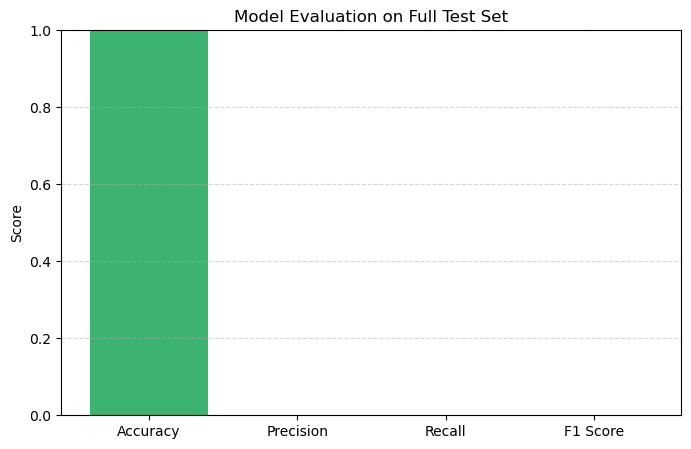

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print("\n🧪 Running full test set evaluation...\n")
model.eval()

y_true_all = []
y_pred_all = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        # Skip if ground truth is completely empty (optional)
        if labels.sum() == 0:
            print(f"⚠️ Skipping empty mask at batch {i+1}")
            continue

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # shape: [B, D, H, W]

        y_pred_all.extend(preds.cpu().numpy().flatten())
        y_true_all.extend(labels.cpu().numpy().flatten())

# === Compute Metrics ===
accuracy = accuracy_score(y_true_all, y_pred_all)
precision = precision_score(y_true_all, y_pred_all, zero_division=0)
recall = recall_score(y_true_all, y_pred_all, zero_division=0)
f1 = f1_score(y_true_all, y_pred_all, zero_division=0)

print(f"\n📊 Full Test Set Metrics:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# === Bar Plot ===
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='mediumseagreen')
plt.ylim(0, 1)
plt.title("Model Evaluation on Full Test Set")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [45]:
# Check how many test samples actually contain lesions
lesion_voxels = []

for batch in test_loader:
    labels = batch["label"]
    lesion_voxels.append(labels.sum().item())

print("Total test batches:", len(lesion_voxels))
print("Batches with lesions:", sum(v > 0 for v in lesion_voxels))


Total test batches: 21
Batches with lesions: 21


In [27]:
import nibabel as nib
from sklearn.model_selection import train_test_split

# Split data based on actual lesion presence
has_lesion = []
no_lesion = []

print("🔍 Scanning label files to split with lesion balance...")

for sample in data:
    label_path = sample["label"]
    label_img = nib.load(label_path).get_fdata()
    
    if label_img.sum() > 0:
        has_lesion.append(sample)
    else:
        no_lesion.append(sample)

print(f"✅ Found {len(has_lesion)} samples with lesions, {len(no_lesion)} without.")

# Ensure we have enough to split
if len(has_lesion) < 2:
    raise ValueError("❌ Not enough samples with lesions to split meaningfully. Add more data or check labels.")

# Stratified split: 80/20 for each group
train_has, test_has = train_test_split(has_lesion, test_size=0.2, random_state=42)
train_no, test_no = train_test_split(no_lesion, test_size=0.2, random_state=42)

# Combine both groups
train_data = train_has + train_no
test_data = test_has + test_no

print(f"📦 Final split — Train: {len(train_data)}, Test: {len(test_data)}")


🔍 Scanning label files to split with lesion balance...
✅ Found 101 samples with lesions, 0 without.


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [37]:
from sklearn.model_selection import train_test_split

# ✅ We only have lesion samples
if len(has_lesion) == 0:
    raise ValueError("❌ No lesion samples found to split.")

# 🔀 Split the lesion samples 80-20
train_data, test_data = train_test_split(has_lesion, test_size=0.2, random_state=42)

print(f"📦 Final split — Train: {len(train_data)}, Test: {len(test_data)}")


📦 Final split — Train: 80, Test: 21


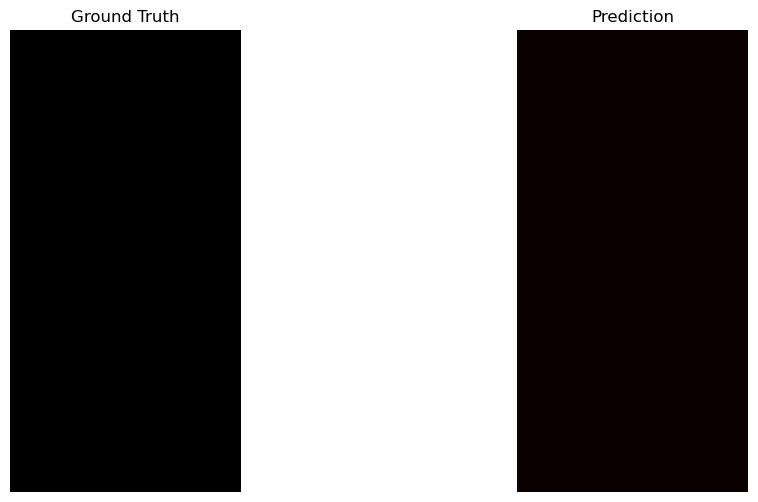

In [23]:
import matplotlib.pyplot as plt

batch = next(iter(test_loader))
model.eval()
with torch.no_grad():
    pred = model(batch["image"].to(device))
    pred_label = torch.argmax(pred, dim=1).cpu().numpy()[0]
    gt_label = batch["label"].numpy()[0][0]

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(gt_label[gt_label.shape[0]//2], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(pred_label[pred_label.shape[0]//2], cmap="hot")
plt.axis("off")
plt.show()
